In [1]:
!pip install statsmodels


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import os

folder_path = "./idling"

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    
    temp_df = pd.read_csv(file_path, parse_dates=["START", "END"])  # Convert to datetime
    temp_df = temp_df.drop(columns=["Unnamed: 5", "Unnamed: 6", "Unnamed: 7"], errors="ignore")
    
    temp_df["idling_duration"] = (temp_df["END"] - temp_df["START"]).dt.total_seconds() / 60  # Convert to minutes
    
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

df = df.sort_values(by="START")

print(df.head())


                   START                 END  UNIT_ID       LAT      LONG  \
1163 2023-12-31 20:02:00 2023-12-31 20:09:00   442940  24.14849  55.83375   
643  2023-12-31 20:05:00 2023-12-31 20:14:00   439949  24.13157  51.62964   
827  2023-12-31 20:05:00 2023-12-31 20:14:00   457718  24.13157  51.62955   
915  2023-12-31 20:06:00 2023-12-31 20:18:00   442910  24.14802  55.83376   
1149 2023-12-31 20:07:00 2023-12-31 20:12:00   442918  24.14843  55.83367   

      idling_duration  
1163              7.0  
643               9.0  
827               9.0  
915              12.0  
1149              5.0  


In [3]:
df["date"] = df["START"].dt.date  

# Group by date and sum up idling durations
daily_idling = df.groupby("date")["idling_duration"].sum().reset_index()

daily_idling["date"] = pd.to_datetime(daily_idling["date"])

daily_idling.set_index("date", inplace=True)

print(daily_idling.head())


            idling_duration
date                       
2023-12-31            517.0
2024-01-01           9613.0
2024-01-02          14370.0
2024-01-03          12850.0
2024-01-04          12596.0


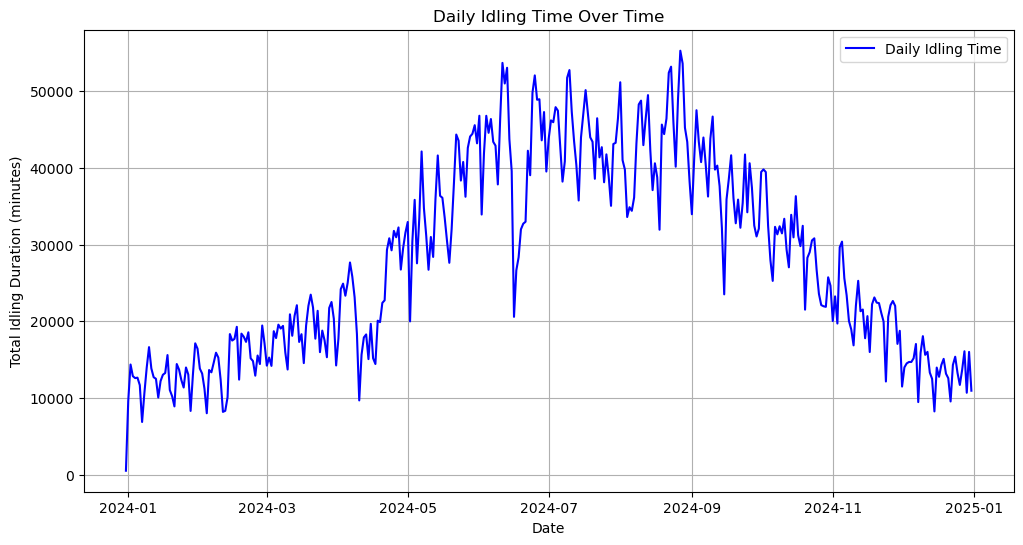

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_idling, label="Daily Idling Time", color="blue", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Total Idling Duration (minutes)")
plt.title("Daily Idling Time Over Time")
plt.legend()
plt.grid()
plt.show()


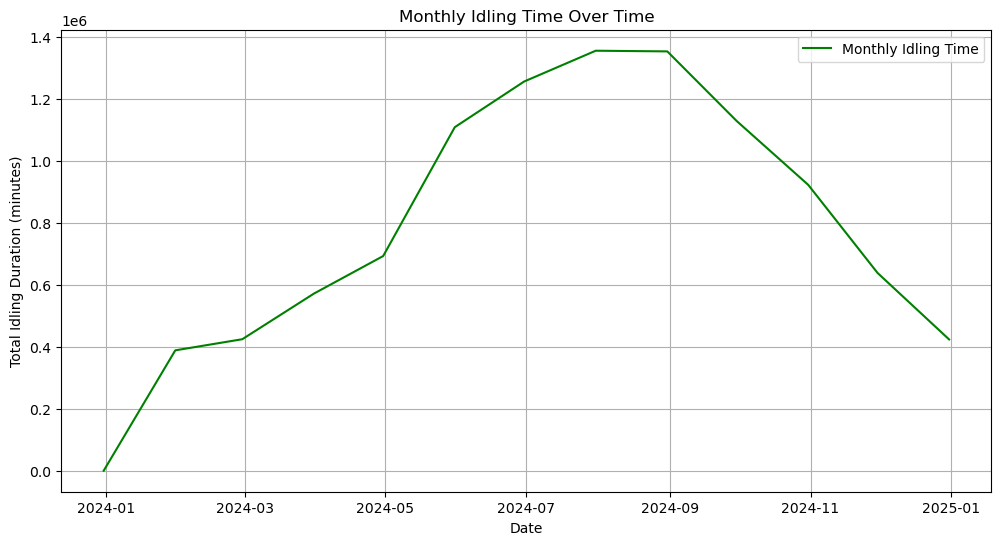

In [5]:
monthly_idling = daily_idling.resample("M").sum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_idling, label="Monthly Idling Time", color="green", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Total Idling Duration (minutes)")
plt.title("Monthly Idling Time Over Time")
plt.legend()
plt.grid()
plt.show()


In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_test = adfuller(monthly_idling)

print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"{key}: {value}")

# Interpretation
if adf_test[1] < 0.05:
    print("\n✅ Data is stationary (reject H0)")
else:
    print("\n⚠️ Data is NOT stationary (fail to reject H0)")


ADF Statistic: -13.55309259890401
p-value: 2.3884192900712263e-25
Critical Values:
1%: -4.6651863281249994
5%: -3.3671868750000002
10%: -2.802960625

✅ Data is stationary (reject H0)


In [10]:
!pip install pmdarima

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   ---------------------------------------- 614.7/614.7 kB 5.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --------------- ------------------------ 1.0/2.8 MB 6.3 MB/s eta 0:00:01
   --------------------------------- ------ 2.4/2.8 MB 5.4 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 4.6 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
print(monthly_idling.shape)
print(monthly_idling.head())


(13, 1)
            idling_duration
date                       
2023-12-31            517.0
2024-01-31         389193.0
2024-02-29         425089.0
2024-03-31         572337.0
2024-04-30         693672.0


In [9]:
from pmdarima import auto_arima

# Fit auto_arima to find optimal SARIMA parameters
auto_model = auto_arima(monthly_idling, seasonal=False, m=12, trace=True, suppress_warnings=True)

print(auto_model.summary())


C:\Users\User\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=395.127, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=362.792, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=391.190, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=358.192, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=358.505, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=356.890, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=361.816, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=359.787, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.515 seconds
                               SARIMAX Results                                
Dep. Variable:                      y

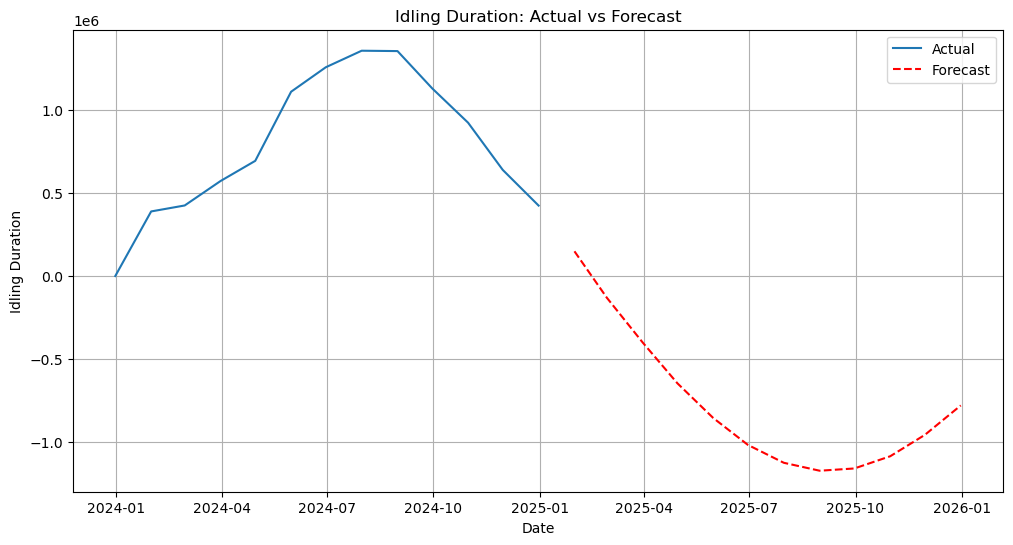

In [10]:
forecast_steps = 12
forecast = auto_model.predict(n_periods=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(monthly_idling.index, monthly_idling['idling_duration'], label="Actual")
forecast_index = pd.date_range(monthly_idling.index[-1], periods=forecast_steps + 1, freq='M')[1:]
plt.plot(forecast_index, forecast, label="Forecast", color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Idling Duration")
plt.title("Idling Duration: Actual vs Forecast")
plt.legend()
plt.grid()
plt.show()
